In [87]:
from gym import Env
from gym.envs.registration import EnvSpec
import numpy as np
from gym.spaces import MultiDiscrete,Box
from graph_tool.all import *
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from makegraph import *
import matplotlib.pyplot as plt

In [2]:
def simulatepandemic(self,actions):
    action = np.divide(actions,np.sum(actions)) #relative availability of vaccine is calculated
    update_state(self.g,action)
    self.state = graph_to_matrix(self.g)
    self.timestep += 1
    return self.state

def initializepandemic(self):
    self.g = make_graph(self.size,self.distribution)
    self.state = graph_to_matrix(self.g)
    return self.state

In [3]:

class PanEnv(Env):
    def __init__(self,size,distribution):
        self.size = size #population size
        self.spec = EnvSpec('GymEnv-v0')
        self.action_space = MultiDiscrete(nvec=[10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10])
        self.observation_space = Box(low=-np.inf,high=np.inf,shape=[self.size,7])
        
        
        self.distribution = distribution #age distribution, country name as string
        self.g = make_graph(self.size,self.distribution)
                
        #state observation as matrix
        self.state = graph_to_matrix(self.g)
        
        self.timestep = 1
    def step(self,actions):
        state = simulatepandemic(self,actions)
        #observation (object): agent's observation of the current environment
        self.reward_1 = -np.sum(state[:,5])
        self.reward_2 = np.sum(state[:,6])
        reward = self.reward_1
        #print(reward)
        #reward (float) : amount of reward returned after previous action
        #negative reward: punishment > change weights a lot, push away from causing weights, positive rewards pull
        #do reward compared to reward from previous step
        #naive example: reward = -sum(infected) > we want a reward where the cumulative sum of infections until end
        #is minimized
        #exp. solution: store information in self, summed infections, normalized by time
        done = False
        if((self.timestep > 19) or np.sum(self.state[:,1])==0):
            done = True
        #done (bool): episode is done after 20 timesteps or when there are no longer infected agents
        info = {}
        #info (dict): contains auxiliary diagnostic information (helpful for debugging, and sometimes learning)'''
        return state, reward, done, info
    def reset(self):
        #returns initial state
        self.state = initializepandemic(self)
        return self.state

In [4]:
from stable_baselines3.common.env_checker import check_env
#check_env(Env)

In [5]:
#matrix representation:
#[S, I, R, Sv, Iv, D]

In [25]:
env = PanEnv(size=1000,distribution='Japan')
env.reset()

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [32]:
actions = np.full(20,1)

In [41]:
env.step(actions)

(array([[0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]]),
 -211.0,
 True,
 {})

In [42]:
print(np.sum(env.state[:,0]),np.sum(env.state[:,1]),np.sum(env.state[:,2]),np.sum(env.state[:,3]),np.sum(env.state[:,4]),)

125.0 0.0 555.0 109.0 0.0


In [7]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.callbacks import BaseCallback
#tensorflow for graphs
import tensorflow as tf
from stable_baselines3.common.evaluation import evaluate_policy
env = PanEnv(size=1000,distribution='Japan')
log_dir = "./gym/"
env = Monitor(env,log_dir)
model = PPO("MlpPolicy",env,verbose=1)
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=100)

2021-12-02 04:42:00.314038: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-02 04:42:00.314080: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Using cpu device
Wrapping the env in a DummyVecEnv.


In [8]:
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:-21.06 +/- 155.98


In [9]:

# Parallel environments

env = DummyVecEnv([lambda: PanEnv(size=1000,distribution='Japan')])

In [10]:
#the class is needed if we want to sample more frequently
'''
https://github.com/DLR-RM/stable-baselines3/issues/309

^^^^^^ this was very helpful ^^^^^^
'''
class TensorboardCallback(BaseCallback):
    """
    Custom callback for plotting additional values in tensorboard.
    """

    def __init__(self, verbose=1):
        super(TensorboardCallback, self).__init__(verbose)
        self.cum_rew_1 = 0
        #self.rew_1 = 0
        
    def _on_rollout_end(self) -> None:
        self.logger.record("rollout/cum_rew_1", self.cum_rew_1)
        #self.logger.record("rollout/rew_1", self.rew_1)
        # reset var once recorded
        self.cum_rew_1 = 0
        self.rew_1 = 0
        

    def _on_step(self) -> bool:
        # Log scalar value (here a random variable)
        #value = np.random.random()
        #self.logger.record('random_value', value)
        
        #self.logger.dump(self.num_timesteps)
        self.cum_rew_1 += self.training_env.get_attr("reward_1")[0]
        #self.rew_1 = self.training_env.get_attr("reward_1")[0]
        return True

In [11]:
model = PPO("MlpPolicy", env, verbose=1,tensorboard_log="./ppo_name_tensorboard/") #multilayer
rewards_callback = TensorboardCallback()
model.learn(total_timesteps=25000,tb_log_name="first_run",callback=rewards_callback) #training loop
#model.save("ppo_cartpole")

#del model # remove to demonstrate saving and loading

#model = PPO.load("ppo_cartpole")
#https://stable-baselines.readthedocs.io/en/master/guide/tensorboard.html?highlight=tensorboard
#^^^ tensorboard for displaying things, but I am stuck, upd: i guess it works now ^^^

Using cpu device
Logging to ./ppo_name_tensorboard/first_run_40
----------------------------------
| rollout/           |           |
|    cum_rew_1       | -2.49e+03 |
| time/              |           |
|    fps             | 6         |
|    iterations      | 1         |
|    time_elapsed    | 306       |
|    total_timesteps | 2048      |
----------------------------------
-----------------------------------------
| rollout/                |             |
|    cum_rew_1            | -578        |
| time/                   |             |
|    fps                  | 6           |
|    iterations           | 2           |
|    time_elapsed         | 674         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.030343514 |
|    clip_fraction        | 0.343       |
|    clip_range           | 0.2         |
|    entropy_loss         | -46         |
|    explained_variance   | 0.000705    |
|    learning_rate        | 0.000

----------------------------------------
| rollout/                |            |
|    cum_rew_1            | -553       |
| time/                   |            |
|    fps                  | 3          |
|    iterations           | 12         |
|    time_elapsed         | 7916       |
|    total_timesteps      | 24576      |
| train/                  |            |
|    approx_kl            | 0.01958017 |
|    clip_fraction        | 0.245      |
|    clip_range           | 0.2        |
|    entropy_loss         | -45.9      |
|    explained_variance   | 6.53e-05   |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0796     |
|    n_updates            | 110        |
|    policy_gradient_loss | -0.0252    |
|    value_loss           | 0.192      |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    cum_rew_1            | -512        |
| time/                   |             |
|    fps    

In [36]:
#after training, reward should have improved
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=100)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:-0.33 +/- 0.47


In [ ]:
model.save("ppo_1")

In [ ]:
gym.spaces??

In [ ]:





mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=100)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

In [95]:
env = PanEnv(size=1000,distribution='Japan')
obs = env.reset()
done = False
obs_storage = []
rewards_storage = []
action_storage = []
while not done:
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    obs_storage.append(obs)
    rewards_storage.append(rewards)
    action_storage.append(action)

In [112]:
def get_sums(obs,index):
    sums = []
    for i in np.arange(0,len(obs)):
        sums.append(np.sum(obs_storage[i][:,index]))
    return sums
def show_pandemic(obs):
    all_sums = []
    for i in np.arange(0,7):
        all_sums.append(get_sums(obs,i))
    sval,ival,rval,vsval,vival,dval,economy_list = all_sums[0],all_sums[1],all_sums[2],all_sums[3],all_sums[4],all_sums[5],all_sums[6]
    tlist = np.arange(0,len(obs))
    plt.figure()
    plt.plot(tlist, sval, label = "S")
    plt.plot(tlist, rval, label = "R")
    plt.plot(tlist, vsval, label = "Sv")
    plt.plot(tlist, vival, label = "Iv")
    plt.plot(tlist, ival, label = "I")
    plt.plot(tlist, dval, label = "D")
    plt.plot(tlist,economy_list, label = "Economy")
    plt.legend()
    plt.show()
def show_actions(actions):
    fo i in np.arange(0,len(obs)):
        
    n, x, _ = plt.hist(action_storage[0], bins=np.linspace(1, 21, 20), 
                   histtype=u'step', density=True)  
    plt.show()

In [115]:
print(action_storage[0])

[5 7 1 4 9 0 2 3 8 2 7 7 2 6 2 2 7 6 2 2]


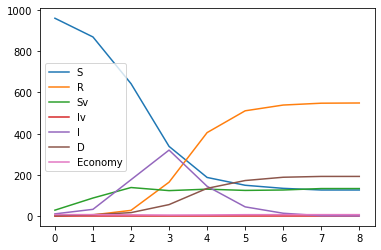

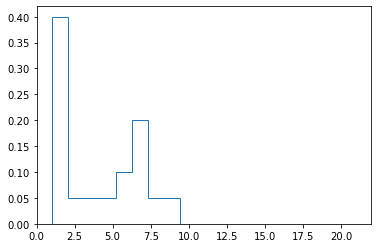

In [118]:
show_pandemic(obs_storage)
n, x, _ = plt.hist(action_storage[0], bins=np.linspace(1, 21, 20), 
                   histtype=u'step', density=True)  
plt.show()

In [ ]:
#split into learning and testing
model.learn(total_timesteps = 5000)
# store/accumulate rewards